In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Load and preprocess dataset
# Step 2: Load and clean data
from google.colab import files
files.upload()
df=pd.read_csv("twitter_training.csv", encoding='latin1')
# df.head(13)
df.columns = ["id", "en tity", "sentiment", "tweet_text"]
df = df.dropna(subset=["tweet_text"])
display(df.head())

Saving twitter_training.csv to twitter_training.csv


,id,en tity,sentiment,tweet_text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [2]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
id            0
en tity       0
sentiment     0
tweet_text    0
dtype: int64


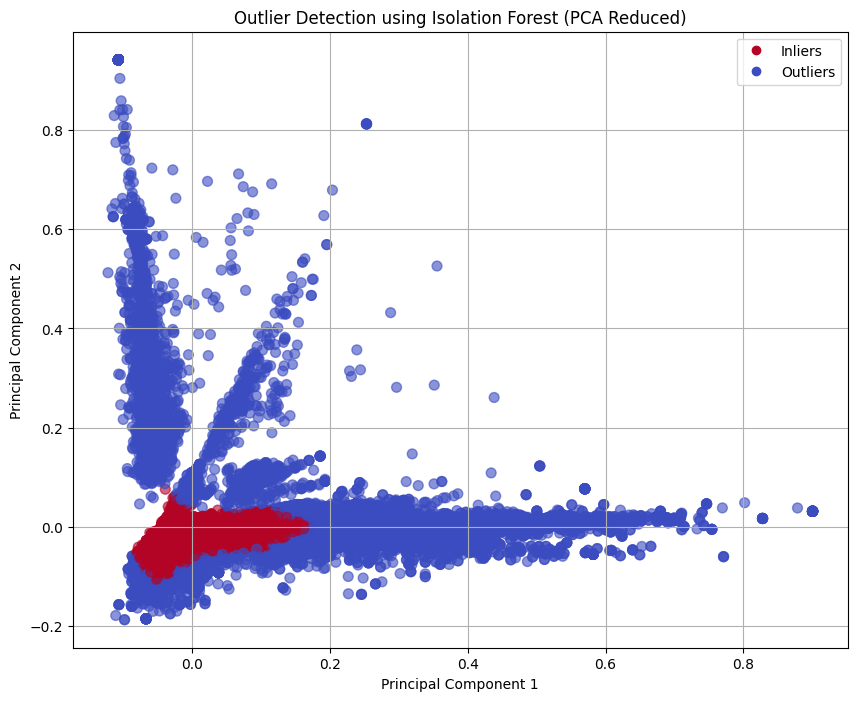

In [3]:
# Detect and Handle Outliers
from sklearn.ensemble import IsolationForest

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000) # Use same parameters as in previous cells
X = vectorizer.fit_transform(df['tweet_text']) # X is now the sparse TF-IDF matrix

# Reduce dimensionality for outlier detection
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray()) # Convert sparse matrix to dense array

# Apply Isolation Forest for outlier detection
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
outliers = iso_forest.fit_predict(X_pca)

# 'outliers' will be an array where -1 indicates an outlier and 1 indicates an inlier
# Visualize outliers in the PCA-reduced space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=outliers, cmap='coolwarm', s=50, alpha=0.6)
plt.title('Outlier Detection using Isolation Forest (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# Create a legend: -1 for outliers, 1 for inliers
legend_labels = {1: 'Inliers', -1: 'Outliers'}
handles = [plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(label)), linestyle='None') for label in legend_labels.keys()]
plt.legend(handles, legend_labels.values())
plt.grid(True)
plt.show()



Cluster distribution:
Cluster
0    39583
1    20694
3     7548
2     6170
Name: count, dtype: int64


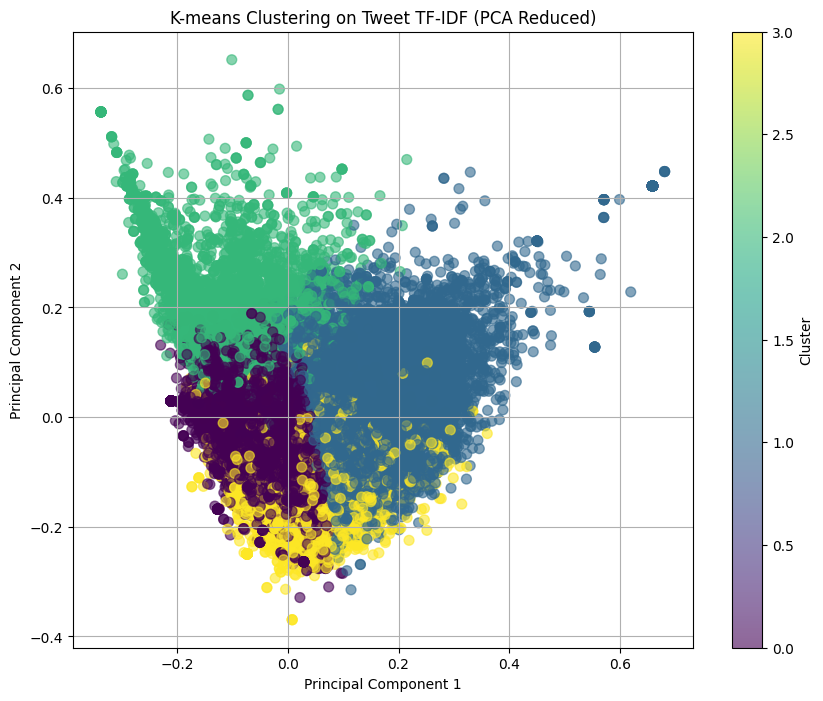

In [4]:
# K-means Clustering algorithm

# Convert sentiment to numerical labels
le = LabelEncoder()
df['Sentiment_Encoded'] = le.fit_transform(df['sentiment'])

# TF-IDF Vectorization on Tweet column
tfidf_vectorizer = TfidfVectorizer(max_features=1000) # Limiting features for simplicity
tfidf_matrix = tfidf_vectorizer.fit_transform(df['tweet_text'])

k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(tfidf_matrix)

# Analyze clustering results
print("\nCluster distribution:")
print(df['Cluster'].value_counts())

# Visualize the clusters
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(tfidf_matrix.toarray()) # PCA works better on dense arrays

df_pca = pd.DataFrame(data = principal_components, columns = ['pca_one', 'pca_two'])
df_pca['Cluster'] = df['Cluster'].reset_index(drop=True) # Ensure indices match
df_pca['Sentiment'] = df['sentiment'].reset_index(drop=True) # Add sentiment for context

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pca['pca_one'], df_pca['pca_two'], c=df_pca['Cluster'], cmap='viridis', s=50, alpha=0.6)
plt.title('K-means Clustering on Tweet TF-IDF (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

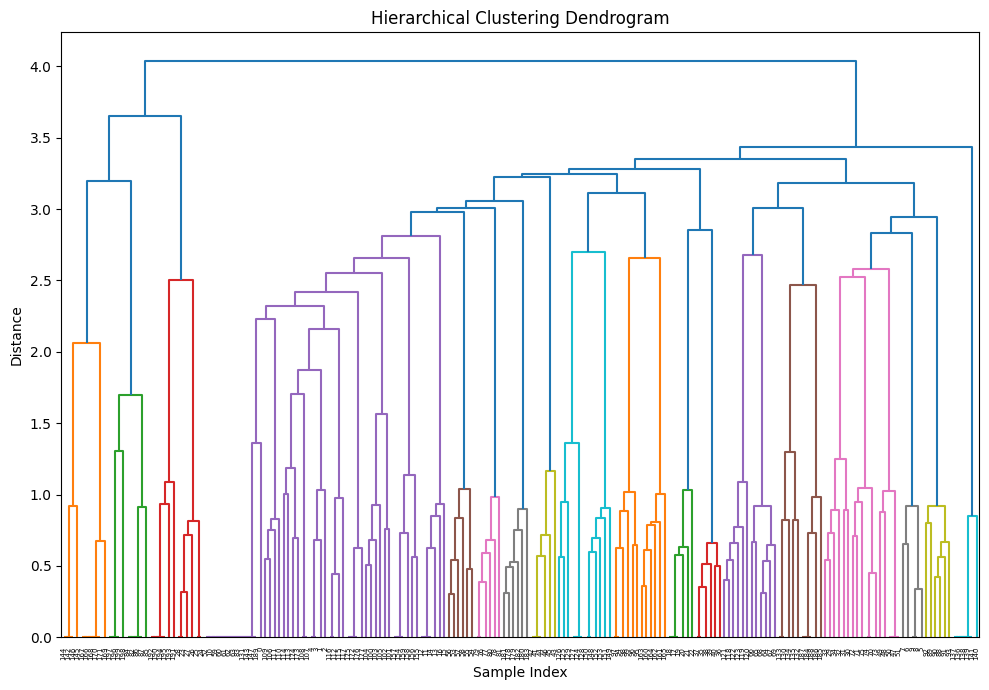

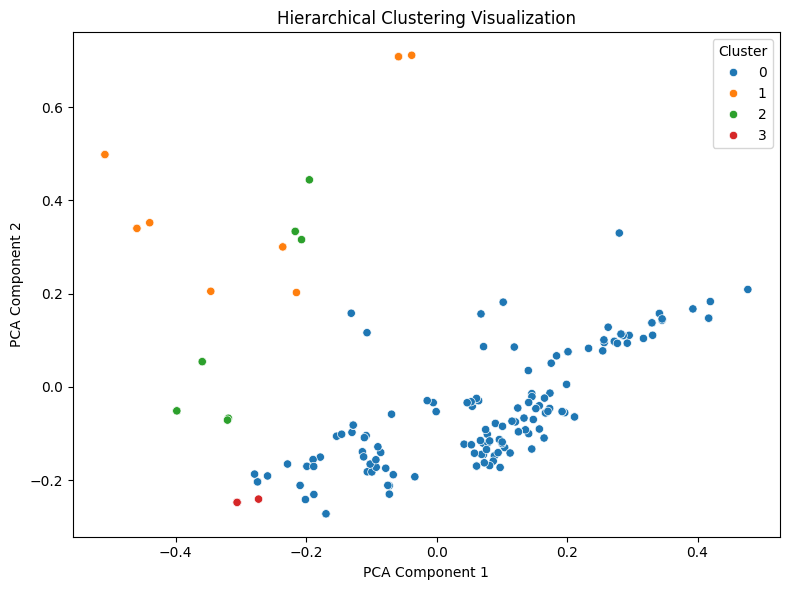

In [5]:
# Hierarchical Clustering Algorithm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage

# Encode labels
y = LabelEncoder().fit_transform(df['sentiment'])
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['tweet_text']).toarray()

# Hierarchical Clustering (Unsupervised)
linked = linkage(X[:200], method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Fit Agglomerative Clustering (e.g., 4 clusters to match 4 sentiment classes)
hc = AgglomerativeClustering(n_clusters=4)
y_hc = hc.fit_predict(X[:200])

# Visualize in 2D using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X[:200])
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y_hc, palette='tab10')
plt.title("Hierarchical Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

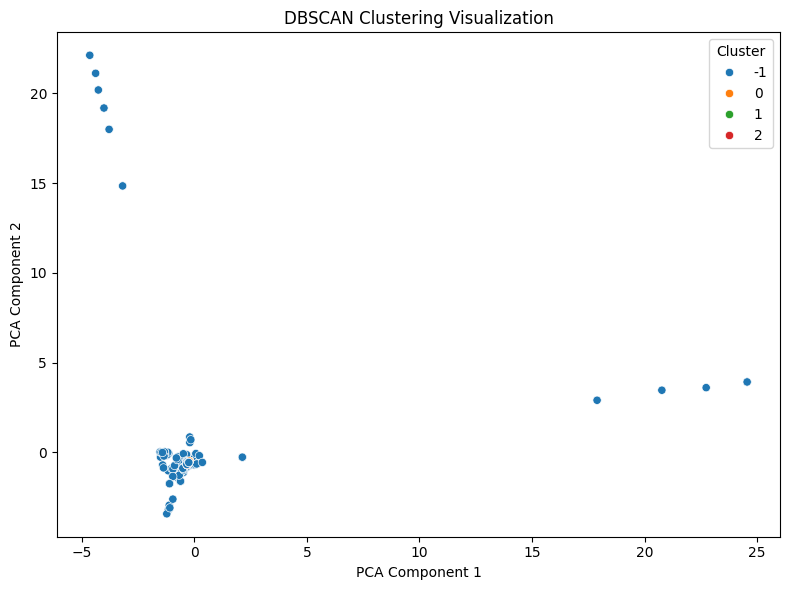

In [6]:
# Density-Based Clustering (DBSCAN) Algorithm

from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X[:200])
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_dbscan = dbscan.fit_predict(X_scaled)

# Visualize DBSCAN results in 2D
X_reduced_db = PCA(n_components=2).fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_reduced_db[:, 0], y=X_reduced_db[:, 1], hue=y_dbscan, palette='tab10', legend='full')
plt.title("DBSCAN Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()